<a href="https://colab.research.google.com/github/JYKnomad/JYKnomad/blob/main/Colaboratory%EC%97%90_%EC%98%A4%EC%8B%A0_%EA%B2%83%EC%9D%84_%ED%99%98%EC%98%81%ED%95%A9%EB%8B%88%EB%8B%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Colab 시작 페이지</h1>

Colab에 이미 익숙하다면 이 동영상을 통해 양방향 테이블, 코드 실행 기록 보기, 명령어 팔레트에 관해 알아보세요.

<center>
  <a href="https://www.youtube.com/watch?v=rNgswRZ2C1Y" target="_blank">
  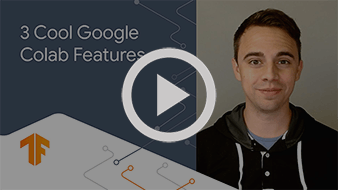
  </a>
</center>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


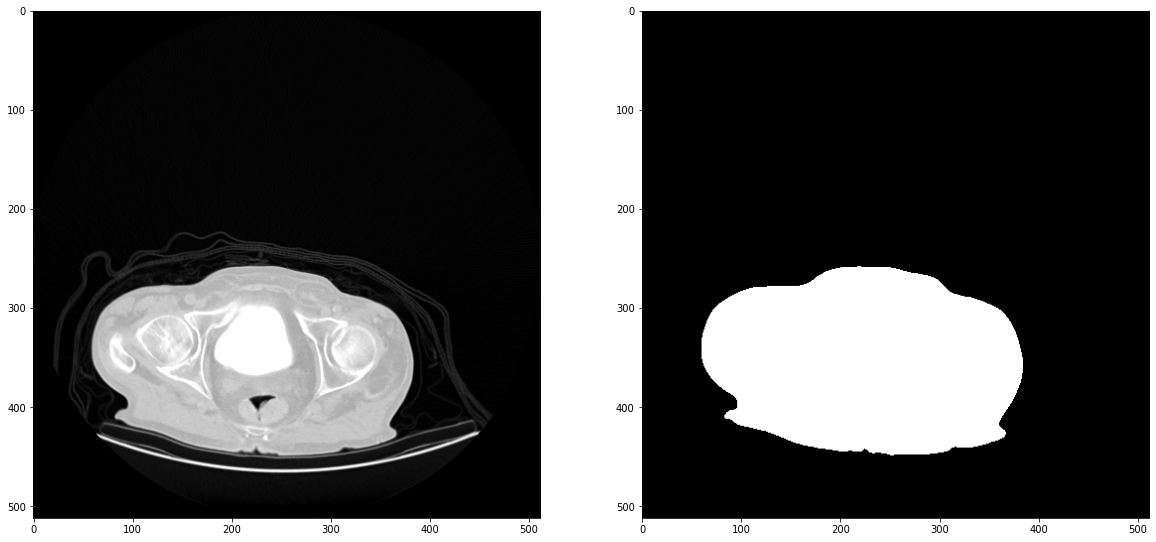

In [3]:
# =========== Segmentation_model (train01+train02)==================
from google.colab import drive
drive.mount('/content/drive')

import cv2
import numpy as np
import imageio
from scipy import ndimage
from glob import glob 
import os
import os.path   
from pandas.core.common import flatten

SAMPLE = 1000

dir_path = "/content/drive/MyDrive/train_set/" 

train_im_paths = []
train_msk_paths = []

for i in range(3):
  train_path = sorted(glob(dir_path+ 'train%02d/' %int(i) +'image/*.jpg'))
  train_im_paths.append(train_path)
  mask_paths = sorted(glob(dir_path+ 'train%02d/' %int(i) +'mask/*.png'))
  train_msk_paths.append(mask_paths)

train_img_paths  = list(flatten(train_im_paths))
train_mask_paths  = list(flatten(train_msk_paths))

train_imgs = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_UNCHANGED), (512,512))
                        for path in train_img_paths])

temp = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_UNCHANGED), (512,512))
                        for path in train_mask_paths])

# ==================
train_masks = []
for elem in temp:
  temp_ = cv2.cvtColor(elem, cv2.COLOR_RGB2GRAY)
  train_masks.append(temp_)

train_masks = np.array(train_masks)
train_masks[train_masks==255] = 0.
train_masks[train_masks==15] = 0.
train_masks[train_masks==3] = 0.
train_masks[train_masks==33] = 1.

train_masks = np.reshape(train_masks, (*train_masks.shape, 1))
train_mask = train_masks.astype(np.float32)

%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[250])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[250]), cmap='gray')


In [ ]:

from PIL import Image
import numpy as np

train_reinput = train_imgs * train_masks 
train_contour = ()
for i in range(0,307): 
  train_contour = Image.fromarray(train_reinput[i])
  train_contour.save("/content/drive/MyDrive/train_set/train01/contour/" + '%03d' %int(i) +".png")
for i in range(307,576): 
  train_contour = Image.fromarray(train_reinput[i])
  train_contour.save("/content/drive/MyDrive/train_set/train02/contour/" + '%03d' for path in train_img_paths %int(i) +".png")
	
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_reinput[250])
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_masks[250]), cmap='gray')

In [ ]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.models import Model


inputs = Input((512, 512, 3))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

from keras import backend as K
from keras.losses import binary_crossentropy

SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

    
from tensorflow.keras.optimizers import Adam
model.compile(Adam(learning_rate=1e-4),
              bce_dice_loss,
              metrics=[binary_crossentropy, dice_coef])
              
              
              
history = model.fit(train_imgs[50:], train_mask[50:],
          batch_size=12, epochs=10,
          validation_data=(train_imgs[:50], train_mask[:50]))

model.save("/content/drive/MyDrive/segmentation")


In [103]:


test_img_paths = sorted(glob('/content/drive/MyDrive/test_set/BC/image/.*.png'))

test_imgs = np.array([cv2.resize(cv2.imread(path, cv2.IMREAD_UNCHANGED), (512,512))
                     for path in test_img_paths])

pred_img=model.predict(test_imgs)


ValueError: ignored

In [ ]:

temp_pred = []
for elem in pred_img:
  bgr_img = cv2.cvtColor(elem, cv2.COLOR_GRAY2RGB)
  temp_pred.append(bgr_img)

dst_imgs_list=[]
for img in temp_pred: 
    nor_img=cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) 
    gray_img = cv2.cvtColor(nor_img, cv2.COLOR_BGR2GRAY)
    ret, dst_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY)
    dst_imgs_list.append(dst_img)
    plt.imshow(dst_img, cmap='gray')
    plt.show()

for i in dst_imgs_list:
  plt.imsave("1-%03d" %int(i) +".png", dst_imgs_list[i], cmap = 'gray')

위 셀의 코드를 실행하려면 셀을 클릭하여 선택한 후 코드 왼쪽의 실행 버튼을 누르거나 단축키 'Command/Ctrl+Enter'를 사용하세요. 셀을 클릭하면 코드 수정을 바로 시작할 수 있습니다.

특정 셀에서 정의한 변수를 나중에 다른 셀에서 사용할 수 있습니다.

In [ ]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

Colab 메모장을 사용하면 <strong>실행 코드</strong>와 <strong>서식 있는 텍스트</strong>를 <strong>이미지</strong>, <strong>HTML</strong>, <strong>LaTeX</strong> 등과 함께 하나의 문서로 통합할 수 있습니다. Colab 메모장을 만들면 Google Drive 계정에 저장됩니다. Colab 메모장을 간편하게 공유하여 동료나 친구들이 댓글을 달거나 수정하도록 할 수 있습니다. 자세히 알아보려면 <a href="/notebooks/basic_features_overview.ipynb">Colab 개요</a>를 참조하세요. 새 Colab 메모장을 만들려면 위의 파일 메뉴를 사용하거나 다음 링크로 이동하세요. <a href="http://colab.research.google.com#create=true">새 Colab 메모장 만들기</a>

Colab 메모장은 Colab에서 호스팅하는 Jupyter 메모장입니다. Jupyter 프로젝트에 관해 자세히 알아보려면 <a href="https://www.jupyter.org">jupyter.org</a>를 참조하세요.

## 데이터 과학

Colab을 통해 인기 있는 Python 라이브러리를 최대한 활용하여 데이터를 분석하고 시각화할 수 있습니다. 아래 코드 셀에서는 <strong>Numpy</strong>를 사용하여 임의의 데이터를 생성하고 <strong>매트플롯립</strong>으로 이를 시각화합니다. 셀을 클릭하면 코드 수정을 바로 시작할 수 있습니다.

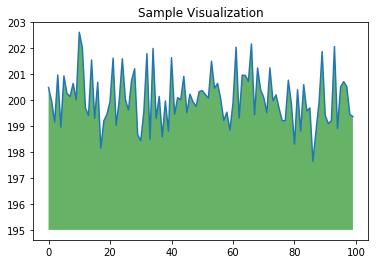

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)

plt.title("Sample Visualization")
plt.show()

Google Drive 계정에서 스프레드시트를 비롯한 데이터를 Colab 메모장으로 가져오거나 GitHub 등의 여러 다른 소스에서 데이터를 가져올 수 있습니다. Colab을 데이터 과학에 활용하는 방법과 데이터 가져오기에 관해 자세히 알아보려면 <a href="#working-with-data">데이터 사용하기</a> 아래 링크를 참조하세요.

## 머신러닝

Colab을 사용하면 <a href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb">코드 몇 줄</a>만으로 이미지 데이터세트를 가져오고, 이 데이터세트로 이미지 분류기를 학습시키며, 모델을 평가할 수 있습니다. Colab 메모장은 Google 클라우드 서버에서 코드를 실행하므로 사용 중인 컴퓨터의 성능과 관계없이 <a href="#using-accelerated-hardware">GPU 및 TPU</a>를 포함한 Google 하드웨어의 성능을 활용할 수 있습니다. 브라우저만 있으면 사용 가능합니다.

Colab은 다음과 같은 분야의 머신러닝 커뮤니티에서 널리 쓰이고 있습니다.
- TensorFlow 시작하기
- 신경망 개발 및 학습시키기
- TPU로 실험하기
- AI 연구 보급하기
- 튜토리얼 만들기

머신러닝 적용 사례를 보여 주는 Colab 메모장 샘플을 확인하려면 아래 <a href="#machine-learning-examples">머신러닝 예시</a>를 참조하세요.

## 추가 리소스

### Colab에서 메모장 사용하기
- [Colaboratory 개요](/notebooks/basic_features_overview.ipynb)
- [Markdown 가이드](/notebooks/markdown_guide.ipynb)
- [라이브러리 가져오기 및 종속 항목 설치하기](/notebooks/snippets/importing_libraries.ipynb)
- [GitHub에서 노트 저장 및 로드하기](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [대화형 양식](/notebooks/forms.ipynb)
- [대화형 위젯](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [Colab의 TensorFlow 2](/notebooks/tensorflow_version.ipynb)

<a name="working-with-data"></a>
### 데이터로 작업하기
- [데이터 로드: 드라이브, 스프레드시트, Google Cloud Storage](/notebooks/io.ipynb) 
- [차트: 데이터 시각화하기](/notebooks/charts.ipynb)
- [BigQuery 시작하기](/notebooks/bigquery.ipynb)

### 머신러닝 단기집중과정
다음은 Google 온라인 머신러닝 과정에서 가져온 일부 메모장입니다. <a href="https://developers.google.com/machine-learning/crash-course/">전체 과정 웹사이트</a>에서 자세한 내용을 확인하세요.
- [Pandas DataFrame 소개](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [합성 데이터를 사용하는 tf.keras 선형 회귀](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)


<a name="using-accelerated-hardware"></a>
### 가속 하드웨어 사용하기
- [GPU를 사용한 TensorFlow](/notebooks/gpu.ipynb)
- [TPU를 사용한 TensorFlow](/notebooks/tpu.ipynb)

<a name="machine-learning-examples"></a>

### 추천 예시

- <a href="https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/VoiceSwapSample.ipynb">NeMo Voice Swap</a>: Nvidia의 NeMo 대화형 AI 툴킷을 사용하여 오디오 파일의 음성을 컴퓨터에서 생성된 음성으로 변환하세요.

- <a href="https://tensorflow.org/hub/tutorials/tf2_image_retraining">이미지 분류기 재훈련</a>: 사전에 훈련된 이미지 분류기를 기반으로 꽃을 분류하기 위한 Keras 모델을 구축합니다.
- <a href="https://tensorflow.org/hub/tutorials/tf2_text_classification">텍스트 분류</a>: IMDB 영화 리뷰를 <em>긍정적인 리뷰</em> 또는 <em>부정적인 리뷰</em>로 분류합니다.
- <a href="https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization">스타일 트랜스퍼</a>: 딥 러닝을 사용하여 이미지 간에 스타일을 전이시킵니다.
- <a href="https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa">Multilingual Universal Sentence Encoder Q&amp;A</a>: 머신러닝 모델을 사용하여 SQuAD 데이터 세트의 질문에 답변합니다.
- <a href="https://tensorflow.org/hub/tutorials/tweening_conv3d">동영상 보간 유형</a>: 동영상에서 첫 프레임과 마지막 프레임 사이에 발생한 내용을 예측합니다.
